In [1]:
from pathlib import Path
import open3d as o3d
import os

from pytorch_lightning import seed_everything

from src.dataset_utils import (
    get_singleview_data,
    get_multiview_data,
    get_voxel_data_json,
    get_image_transform_latent_model,
    get_pointcloud_data,
    get_mv_dm_data,
    get_sv_dm_data,
    get_sketch_data
)
from src.model_utils import Model
from src.mvdream_utils import load_mvdream_model
import argparse
from PIL import Image


from comet_ml import start
from comet_ml.integration.pytorch import log_model
from comet_ml.api import API

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:


experiment = start(
  api_key="mqrUAXjKBRul24uX6pxR3gRHX*eyJiYXNlVXJsIjoiaHR0cHM6Ly9jb21ldC5kZXYuY2xvdWRvcy5hdXRvZGVzay5jb20ifQ",
  project_name="wala-time-checks",
  workspace="alessandro-giuliano"
)

COMET INFO: An experiment with the same configuration options is already running and will be reused.


In [18]:

def simplify_mesh(obj_path, target_num_faces=1000):
    mesh = o3d.io.read_triangle_mesh(obj_path)
    simplified_mesh = mesh.simplify_quadric_decimation(target_num_faces)
    o3d.io.write_triangle_mesh(obj_path, simplified_mesh)


def generate_3d_object(
    model,
    data,
    data_idx,
    scale,
    diffusion_rescale_timestep,
    save_dir="examples",
    output_format="obj",
    target_num_faces=None,
    seed=42,
    
):
    # Set seed
    seed_everything(seed, workers=True)

    save_dir.mkdir(parents=True, exist_ok=True)
    model.set_inference_fusion_params(scale, diffusion_rescale_timestep)
    output_path = model.test_inference(
        data, data_idx, experiment, save_dir=save_dir, output_format=output_format
    )

    if output_format == "obj" and target_num_faces:
        simplify_mesh(output_path, target_num_faces=target_num_faces)


In [19]:
model_name = 'ADSKAILab/WaLa-SV-1B'
images_path = Path('examples/single_view/')
single_image = ['examples/single_view/table.png']

output_dir = 'examples/Test_Gen'
output_format = 'obj'
target_num_faces = None
scale = 1.8
seed = 42
diffusion_rescale_timestep = 5



In [20]:
print(f"Loading model")

model = Model.from_pretrained(pretrained_model_name_or_path=model_name)
image_transform = get_image_transform_latent_model()

for image_path in single_image:
    print(f"Processing image: {image_path}")
    data = get_singleview_data(
        image_file=Path(image_path),
        image_transform=image_transform,
        device=model.device,
        image_over_white=False,
    )
    data_idx = 0
    save_dir = Path(output_dir) / Path(image_path).stem

    model.set_inference_fusion_params(
        scale, diffusion_rescale_timestep
    )

    generate_3d_object(
        model,
        data,
        data_idx,
        scale,
        diffusion_rescale_timestep,
        save_dir,
        output_format,
        target_num_faces,
        seed
    )


    

Loading model
'DotDict' object has no attribute 'dataset_path'
'DotDict' object has no attribute 'low_avg'
'DotDict' object has no attribute 'low_avg'
Low avg used : None high value: 63


/opt/miniconda/envs/wala/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.1.0
Using cache found in /home/ray/.cache/torch/hub/facebookresearch_dinov2_main
/home/ray/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ray/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ray/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


cond_emb_dim: 1024
Input resolution: 224
Vocab size: N/A
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


Seed set to 42


Processing image: examples/single_view/table.png
Extract Image 0.12564563751220703 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.402419090270996 s
Latent Decoding Time 0.0975334644317627 s
Wavelet Preparation Time 0.0002522468566894531 s
Low to Highs conversion 0.2680997848510742 s
Inverse DWT time elapsed 0.010677576065063477 s
mcubes.marching_cubes time 0.5867412090301514 s
export obj time 2.3584489822387695 s
Time to save visualization from high lows to obj 2.9565439224243164 s


In [6]:
import time


for idx, image_path in enumerate(images_path.iterdir()):  # Enumerate to get the index
    timer1 = time.time()
    print(f"Processing image: {image_path}")
    data = get_singleview_data(
        image_file=Path(image_path),
        image_transform=image_transform,
        device=model.device,
        image_over_white=False,
    )
    data_idx = 0
    save_dir = Path(output_dir) 

    model.set_inference_fusion_params(
        scale, diffusion_rescale_timestep
    )

    generate_3d_object(
        model,
        data,
        data_idx,
        scale,
        diffusion_rescale_timestep,
        save_dir,
        output_format,
        target_num_faces,
        seed,
    )
    delta = time.time() - timer1
    experiment.log_metric("Default Delta", delta)
    print('Total Inference time', delta)

experiment.end()

Seed set to 42


Processing image: examples/single_view/table.png
Extract Image 0.016147613525390625 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.348755121231079 s
Latent Decoding Time 0.005625724792480469 s
Wavelet Preparation Time 0.00020551681518554688 s
Low to Highs conversion 0.27273058891296387 s
Inverse DWT time elapsed 0.0033140182495117188 s
mcubes.marching_cubes time 0.5861926078796387 s


Seed set to 42


export obj time 2.3593924045562744 s
Time to save visualization from high lows to obj 2.9496212005615234 s
Total Inference time 5.6073362827301025
Processing image: examples/single_view/apple.jpeg
Extract Image 0.014613866806030273 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.353048324584961 s
Latent Decoding Time 0.0043375492095947266 s
Wavelet Preparation Time 0.0001518726348876953 s
Low to Highs conversion 0.2792699337005615 s
Inverse DWT time elapsed 0.004033088684082031 s
mcubes.marching_cubes time 0.5573968887329102 s


Seed set to 42


export obj time 2.0231595039367676 s
Time to save visualization from high lows to obj 2.5854058265686035 s
Total Inference time 5.2440409660339355
Processing image: examples/single_view/pear.jpeg
Extract Image 0.014765024185180664 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3535726070404053 s
Latent Decoding Time 0.004456758499145508 s
Wavelet Preparation Time 0.00014972686767578125 s
Low to Highs conversion 0.24218201637268066 s
Inverse DWT time elapsed 0.0028891563415527344 s
mcubes.marching_cubes time 0.5516839027404785 s


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : fashionable_durian_9726
COMET INFO:     url                   : https://comet.dev.cloudos.autodesk.com/alessandro-giuliano/wala-time-checks/b8a38b6c4e3749158d63843fccbaea46
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Default Delta [3]                                    : (4.964773178100586, 5.6073362827301025)
COMET INFO:     Extract Image [4]                                    : (0.014613866806030273, 0.12229490280151367)
COMET INFO:     Inverse DWT time elapsed [4]                         : (0.0028891563415527344, 0.011530399322509766)
COMET INFO:     Latent Decoding Time [4]                             : (0.0043375492095947266, 0.084

export obj time 1.786191463470459 s
Time to save visualization from high lows to obj 2.3415040969848633 s
Total Inference time 4.964773178100586


## Dataset Extraction and Utilization for Benchmarking

### Dataset download and extraction

In [ ]:
import zipfile
from pathlib import Path
import os
import shutil

zip_dir = '/home/ray/WaLa/Raw_data'         # Folder with zip files
output_dir = '/home/ray/WaLa/test_images'  # Where to save extracted thumbnails
os.makedirs(output_dir, exist_ok=True)

for zip_path in Path(zip_dir).glob('*.zip'):
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Find files in the 'thumbnail' folder (not subfolders)
        thumbnail_files = [f for f in z.namelist() if f.startswith('thumbnails/') and not f.endswith('/')]
        if thumbnail_files:
            thumb_file = thumbnail_files[0]  # Pick the first one
            ext = Path(thumb_file).suffix
            out_name = zip_path.stem + ext
            out_path = Path(output_dir) / out_name
            with z.open(thumb_file) as source, open(out_path, 'wb') as target:
                shutil.copyfileobj(source, target)
            print(f"Extracted {thumb_file} from {zip_path.name} as {out_name}")

In [ ]:
from pathlib import Path

def count_extracted_images(target_folder, extensions={'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}):
    """
    Counts the number of image files in the target folder.
    Args:
        target_folder (str or Path): Path to the folder to check.
        extensions (set): Set of file extensions to consider as images.
    Returns:
        int: Number of image files found.
    """
    target_folder = Path(target_folder)
    return sum(1 for f in target_folder.iterdir() if f.suffix.lower() in extensions and f.is_file())

num_images = count_extracted_images('/home/ray/WaLa/test_images')  # Where to save extracted thumbnails
print(f"Extracted images: {num_images}")

Extracted images: 0


### Dataset Inference Tests

In [25]:
from comet_ml import start
from comet_ml.integration.pytorch import log_model
import time

experiment = start(
  api_key="mqrUAXjKBRul24uX6pxR3gRHX*eyJiYXNlVXJsIjoiaHR0cHM6Ly9jb21ldC5kZXYuY2xvdWRvcy5hdXRvZGVzay5jb20ifQ",
  project_name="wala-time-checks",
  workspace="alessandro-giuliano")


  # Define the hyperparameters
hyperparameters = {
    "model_name": "ADSKAILab/WaLa-SV-1B",
    "images_path": str(Path("examples/single_view/")),
    "single_image": ["examples/single_view/table.png"],
    "output_dir": "examples/Test_Gen",
    "output_format": "obj",
    "target_num_faces": None,
    "scale": 1.8,
    "seed": 42,
    "diffusion_rescale_timestep": 5
}

# Log the hyperparameters to Comet
experiment.log_parameters(hyperparameters)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://comet.dev.cloudos.autodesk.com/alessandro-giuliano/wala-time-checks/1bf42d8c3ee545628968903512893acf



In [ ]:
### Scanned Objects by Google Research
google_test_img_path = Path(os.path.expanduser('~/test_images'))  # Expands '~' to the full home directory path
output_dir = os.path.expanduser('~/Obj_generated')

for idx, image_path in enumerate(google_test_img_path.iterdir()):  # Enumerate to get the index
        #if idx >= 3:  # Stop after processing the first 3 files
            #break
        print(f"Processing image {idx + 1}: {image_path}")



        timer1 = time.time()
        data = get_singleview_data(
            image_file=Path(image_path),
            image_transform=image_transform,
            device=model.device,
            image_over_white=False,
        )
        data_idx = 0
        save_dir = Path(output_dir) 

        model.set_inference_fusion_params(
            scale, diffusion_rescale_timestep
        )

        generate_3d_object(
            model,
            data,
            data_idx,
            scale,
            diffusion_rescale_timestep,
            save_dir,
            output_format,
            target_num_faces,
            seed,
        )
        delta = time.time() - timer1
        experiment.log_metric("Default Delta", delta)
        print('Total Inference time', delta)

experiment.end()

### Data Visualization

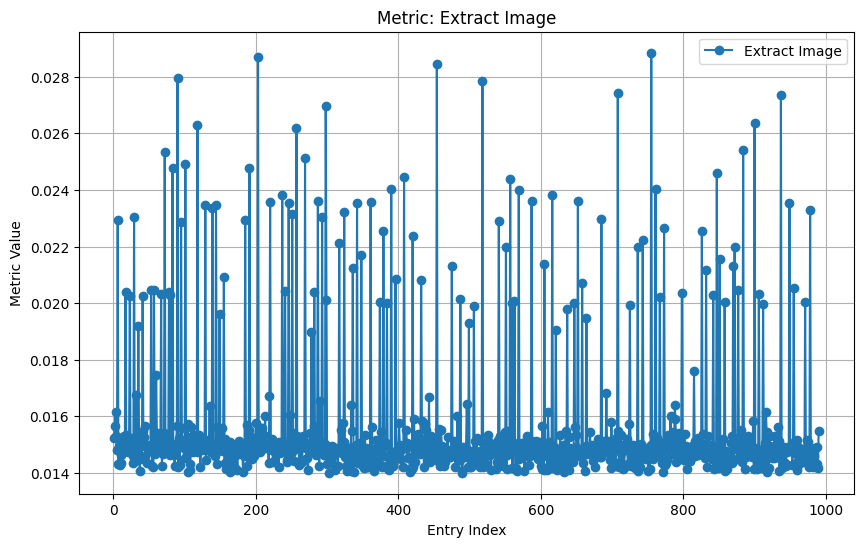

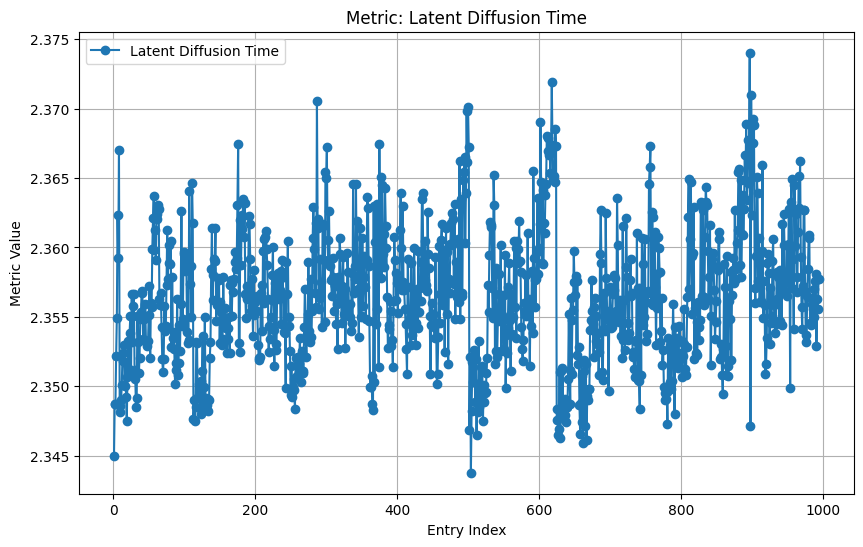

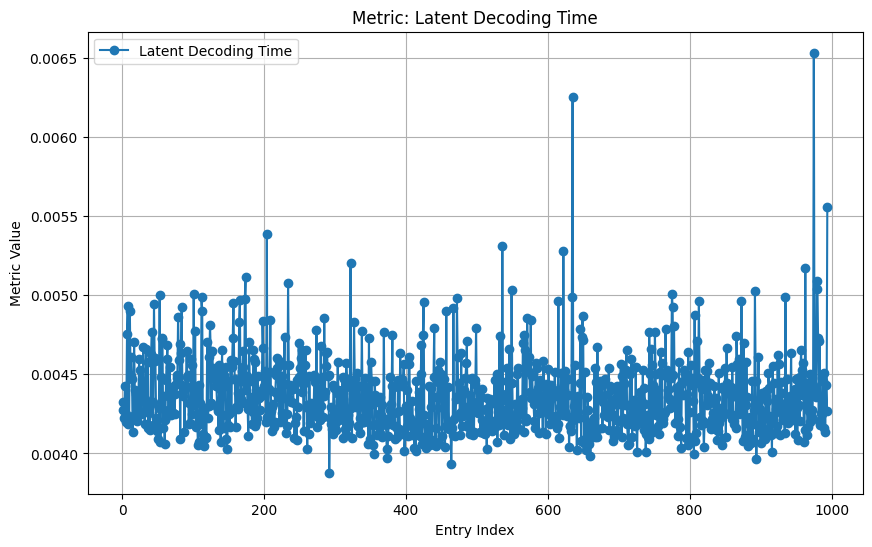

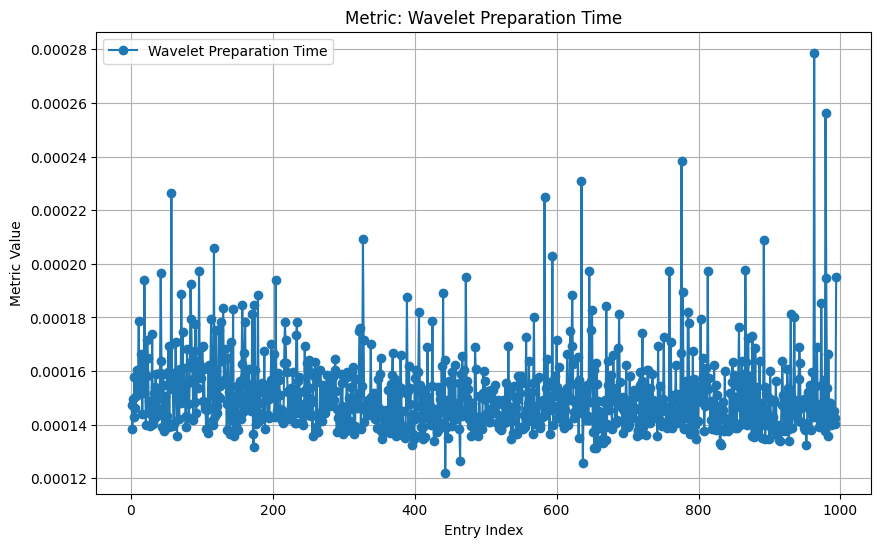

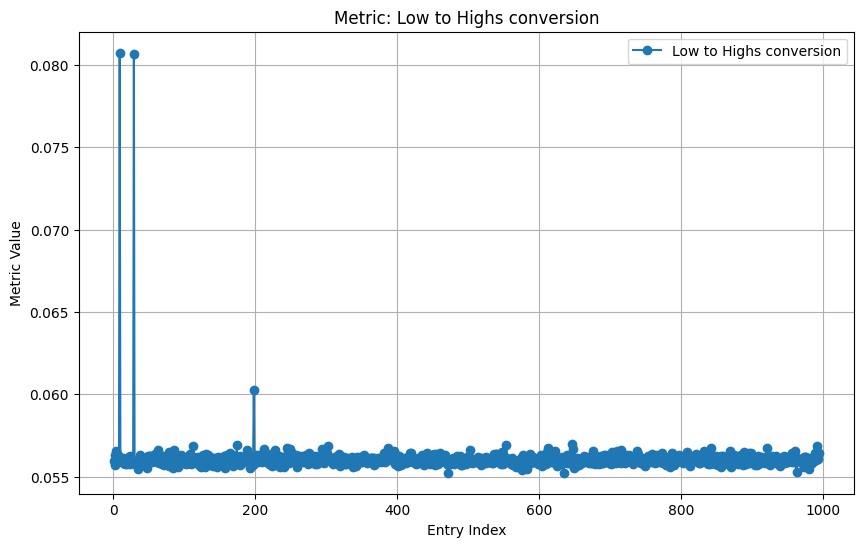

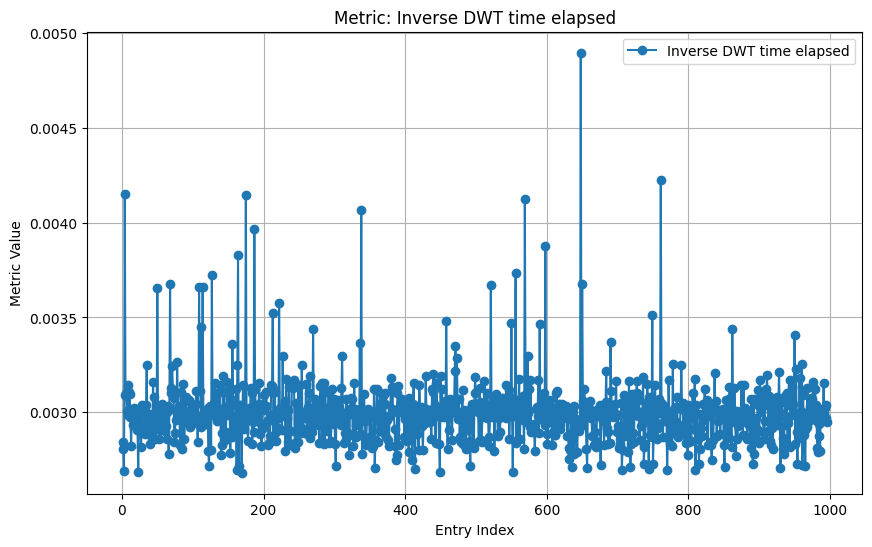

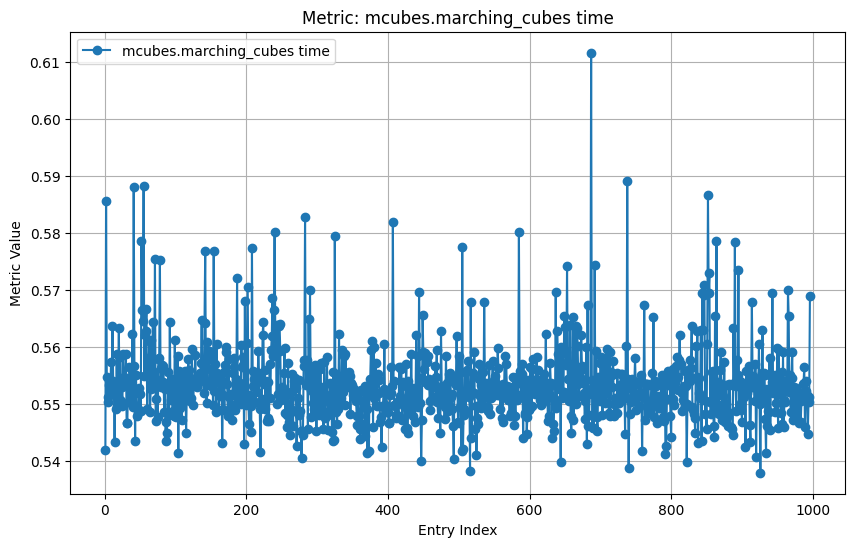

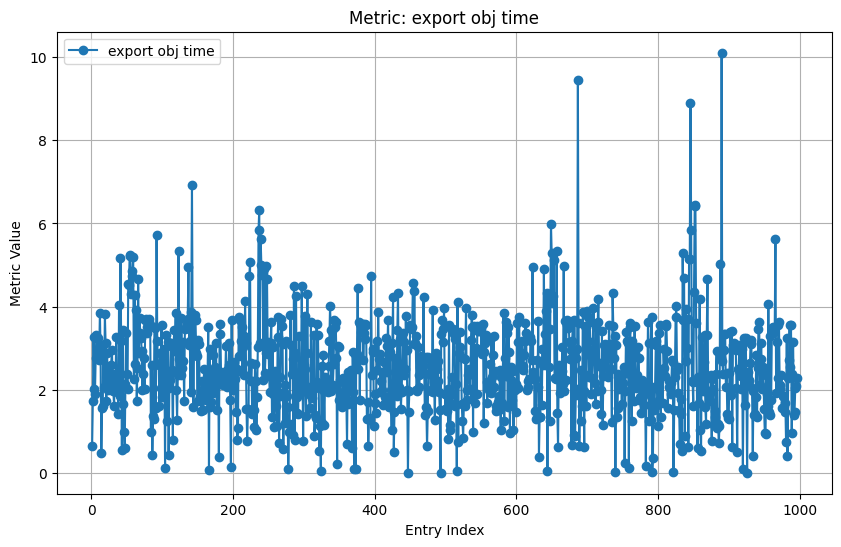

In [19]:
api_key="mqrUAXjKBRul24uX6pxR3gRHX*eyJiYXNlVXJsIjoiaHR0cHM6Ly9jb21ldC5kZXYuY2xvdWRvcy5hdXRvZGVzay5jb20ifQ"
comet_api = API(api_key=api_key)
project_name="wala-time-checks"
workspace="alessandro-giuliano"
experiment_key = '1bf42d8c3ee545628968903512893acf'
# Retrieve the experiment
experiment = comet_api.get_experiment(workspace, project_name, experiment_key)

# Retrieve metrics from the experiment
metrics = experiment.get_metrics_summary()

# List of metric names to plot
metric_names = [
    "Extract Image",
    "Latent Diffusion Time",
    "Latent Decoding Time",
    "Wavelet Preparation Time",
    "Low to Highs conversion",
    'Inverse DWT time elapsed',    
    "mcubes.marching_cubes time",
    "export obj time"
]

# Plot each metric in a separate graph
for metric_name in metric_names:
    # Retrieve metric data
    metric_data = experiment.get_metrics(metric_name)
    # Extract values and convert to float
    values = [float(point["metricValue"]) for point in metric_data]
    # Create x-axis as entry indices
    x_axis = list(range(1, len(values) + 1))
    
    # Create a new figure for each metric
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis, values, label=metric_name, marker='o')
    plt.xlabel("Entry Index")
    plt.ylabel("Metric Value")
    plt.title(f"Metric: {metric_name}")
    plt.legend()
    plt.grid()
    plt.show()

In [20]:
# Retrieve and calculate statistics for each metric
metric_statistics = {}
total_sum = 0

for metric_name in metric_names:
    # Retrieve metric data
    metric_data = experiment.get_metrics(metric_name)
    # Extract values and convert to float
    values = [float(point["metricValue"]) for point in metric_data]
    
    # Calculate statistics
    metric_stats = {
        "mean": np.mean(values),
        "median": np.median(values),
        "min": np.min(values),
        "max": np.max(values),
        "sum": np.sum(values)
    }
    metric_statistics[metric_name] = metric_stats
    total_sum += metric_stats["sum"]

# Retrieve the "Default Delta" metric
default_delta_data = experiment.get_metrics("Default Delta")
default_delta_values = [float(point["metricValue"]) for point in default_delta_data]
default_delta_sum = np.sum(default_delta_values)

# Display statistics
print("Metric Statistics:")
for metric_name, stats in metric_statistics.items():
    print(f"\n{metric_name}:")
    for stat_name, value in stats.items():
        print(f"  {stat_name.capitalize()}: {value:.4f}")

print(f"\nTotal Sum of All Metrics (excluding Default Delta): {total_sum:.4f}")
print(f"Default Delta Sum: {default_delta_sum:.4f}")

# Check if the total sum is close to the Default Delta
if np.isclose(total_sum, default_delta_sum, atol=20):  # Adjust tolerance as needed
    # Calculate the percentage difference
    percentage_difference = (total_sum / default_delta_sum) * 100

    # Print the result
    print(f"\nThe total sum of all metrics is {percentage_difference:.2f}% of the Default Delta.")
else:
    print("\nThe total sum of all metrics is NOT close to the Default Delta.")


Metric Statistics:

Extract Image:
  Mean: 0.0156
  Median: 0.0148
  Min: 0.0140
  Max: 0.0289
  Sum: 15.4203

Latent Diffusion Time:
  Mean: 2.3564
  Median: 2.3561
  Min: 2.3438
  Max: 2.3740
  Sum: 2342.2222

Latent Decoding Time:
  Mean: 0.0044
  Median: 0.0043
  Min: 0.0039
  Max: 0.0065
  Sum: 4.3371

Wavelet Preparation Time:
  Mean: 0.0002
  Median: 0.0001
  Min: 0.0001
  Max: 0.0003
  Sum: 0.1500

Low to Highs conversion:
  Mean: 0.0561
  Median: 0.0560
  Min: 0.0552
  Max: 0.0807
  Sum: 55.7399

Inverse DWT time elapsed:
  Mean: 0.0030
  Median: 0.0030
  Min: 0.0027
  Max: 0.0049
  Sum: 2.9833

mcubes.marching_cubes time:
  Mean: 0.5534
  Median: 0.5527
  Min: 0.5379
  Max: 0.6116
  Sum: 551.1406

export obj time:
  Mean: 2.5208
  Median: 2.3933
  Min: 0.0027
  Max: 10.1085
  Sum: 2510.6694

Total Sum of All Metrics (excluding Default Delta): 5482.6627
Default Delta Sum: 5498.1748

The total sum of all metrics is 99.72% of the Default Delta.


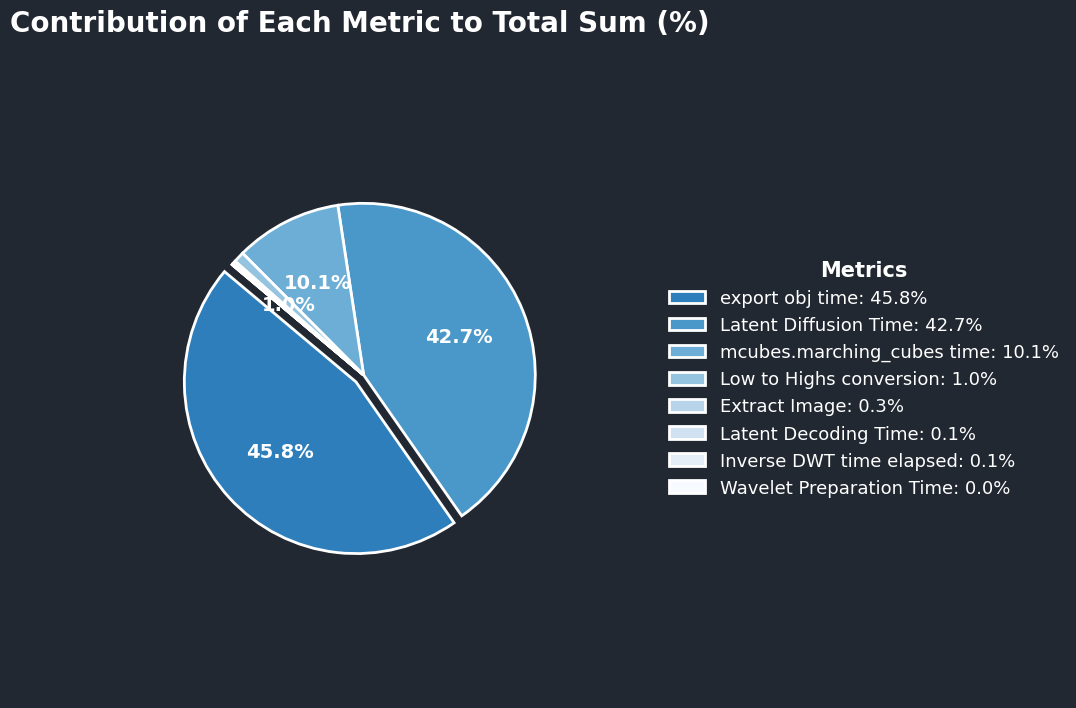

In [33]:

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Sans'

# Prepare and sort data for the pie chart
labels = []
sizes = []

for metric_name, stats in metric_statistics.items():
    labels.append(metric_name)
    sizes.append(stats["sum"])

# Calculate percentages
total = sum(sizes)
percentages = [size / total * 100 for size in sizes]

# Sort by size (descending)
sorted_indices = np.argsort(sizes)[::-1]
labels = [labels[i] for i in sorted_indices]
sizes = [sizes[i] for i in sorted_indices]
percentages = [percentages[i] for i in sorted_indices]

# Use an inverted (reversed) colormap for light slices
cmap = plt.get_cmap('Blues_r')
colors = [cmap(0.3 + 0.7 * i / (len(labels)-1)) for i in range(len(labels))]

# Explode the largest slice
explode = [0.06 if i == 0 else 0 for i in range(len(labels))]

fig, ax = plt.subplots(figsize=(11, 8))
fig.patch.set_facecolor('#222831')  # Dark background
ax.set_facecolor('#222831')

# Pie chart with white edge, no shadow
wedges, texts, autotexts = ax.pie(
    sizes,
    colors=colors,
    startangle=140,
    autopct=lambda pct: f"{pct:.1f}%" if pct > 0.5 else '',
    textprops={'fontsize': 14, 'fontweight': 'bold', 'color': 'white'},
    explode=explode,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}
)

# Add a legend with full labels and percentages
legend_labels = [f"{label}: {percent:.1f}%" for label, percent in zip(labels, percentages)]
legend = ax.legend(
    wedges, legend_labels, title="Metrics", loc="center left",
    bbox_to_anchor=(1.05, 0.5), fontsize=13, title_fontsize=15, frameon=False, labelcolor='white'
)
plt.setp(legend.get_title(), fontweight='bold', color='white')

plt.title('Contribution of Each Metric to Total Sum (%)', fontsize=20, fontweight='bold', pad=20, color='white')
plt.axis('equal')
plt.tight_layout(pad=4)
plt.show()

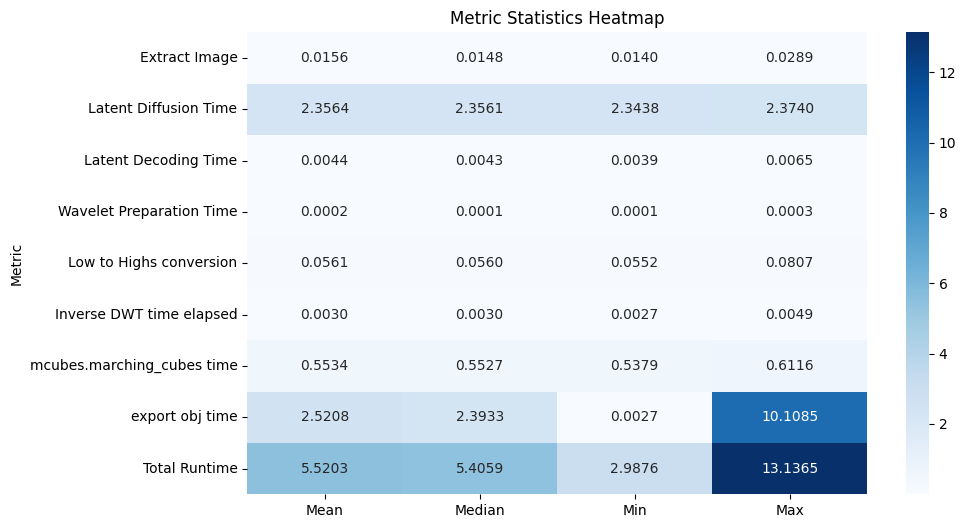

In [35]:


# Convert metric_statistics to a DataFrame
data = {
    "Metric": [],
    "Mean": [],
    "Median": [],
    "Min": [],
    "Max": []
}

for metric_name, stats in metric_statistics.items():
    data["Metric"].append(metric_name)
    data["Mean"].append(stats["mean"])
    data["Median"].append(stats["median"])
    data["Min"].append(stats["min"])
    data["Max"].append(stats["max"])

# Add Default Delta statistics
default_delta_stats = {
    "mean": np.mean(default_delta_values),
    "median": np.median(default_delta_values),
    "min": np.min(default_delta_values),
    "max": np.max(default_delta_values)
}

data["Metric"].append("Total Runtime")
data["Mean"].append(default_delta_stats["mean"])
data["Median"].append(default_delta_stats["median"])
data["Min"].append(default_delta_stats["min"])
data["Max"].append(default_delta_stats["max"])

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(df.set_index("Metric"), annot=True, fmt=".4f", cmap="Blues")
plt.title("Metric Statistics Heatmap")
plt.show()